#libraries

In [ ]:
!pip install libtiff
!pip install scipy==1.1.0
!pip install future
import PIL
from PIL import Image
import matplotlib.pyplot as plt
from libtiff import TIFF
from libtiff import TIFFfile, TIFFimage
from tensorflow.keras.layers import Conv2D
from scipy.misc import imresize
import numpy as np
import math
import glob
import cv2
import os
import skimage.io as io
import skimage.transform as trans
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as keras
from scipy.misc import imsave
from keras import backend as K

#Reading the images

In [ ]:
# To read the images in numerical order
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# List of file names of actual Satellite images for traininig
filelist_trainx = sorted(glob.glob('/content/drive/My Drive/dataset/sat/*.tif'), key=numericalSort)
# List of file names of classified images for traininig
filelist_trainy = sorted(glob.glob('/content/drive/My Drive/dataset/gt/*.tif'), key=numericalSort)

# List of file names of actual Satellite images for testing
filelist_testx = sorted(glob.glob('/content/drive/My Drive/dataset/sat_test/*.tif'), key=numericalSort)

In [ ]:
print(filelist_testx)

['/content/drive/My Drive/dataset/sat_test/1.tif', '/content/drive/My Drive/dataset/sat_test/2.tif', '/content/drive/My Drive/dataset/sat_test/3.tif', '/content/drive/My Drive/dataset/sat_test/4.tif', '/content/drive/My Drive/dataset/sat_test/5.tif', '/content/drive/My Drive/dataset/sat_test/6.tif']


#Preprocessing

#### Resizing the image to nearest dimensions multipls of 'stride'

In [ ]:
 def resize(img, stride, n_h, n_w):
    #h,l,_= img.shape
    ne_h = (n_h*stride) + stride
    ne_w = (n_w*stride) + stride

    img_resized = imresize(img, (ne_h,ne_w))
    return img_resized

#### Padding at the bottem and at the left of images to be able to crop them into 128*128 images for training

In [ ]:
def padding(img, w, h, c, crop_size, stride, n_h, n_w):

    w_extra = w - ((n_w-1)*stride)
    w_toadd = crop_size - w_extra

    h_extra = h - ((n_h-1)*stride)
    h_toadd = crop_size - h_extra

    img_pad = np.zeros(((h+h_toadd), (w+w_toadd), c))
    #img_pad[:h, :w,:] = img
    #img_pad = img_pad+img
    img_pad = np.pad(img, [(0, h_toadd), (0, w_toadd), (0,0)], mode='constant')

    return img_pad

#### Adding pixels to make the image with shape in multiples of stride

In [ ]:
def add_pixals(img, h, w, c, n_h, n_w, crop_size, stride):

    w_extra = w - ((n_w-1)*stride)
    w_toadd = crop_size - w_extra

    h_extra = h - ((n_h-1)*stride)
    h_toadd = crop_size - h_extra

    img_add = np.zeros(((h+h_toadd), (w+w_toadd), c))

    img_add[:h, :w,:] = img
    img_add[h:, :w,:] = img[:h_toadd,:, :]
    img_add[:h,w:,:] = img[:,:w_toadd,:]
    img_add[h:,w:,:] = img[h-h_toadd:h,w-w_toadd:w,:]

    return img_add

#### Slicing the image into crop_size*crop_size crops with a stride of 32 and makking list out of them

In [ ]:
def crops(a, crop_size = 128):

    #stride = int(crop_size/2)
    stride = 32

    croped_images = []
    h, w, c = a.shape

    n_h = int(int(h/stride))
    n_w = int(int(w/stride))

    # Padding using the padding function we wrote
    a = padding(a, w, h, c, crop_size, stride, n_h, n_w)
    for i in range(n_h-1):
        for j in range(n_w-1):
            crop_x = a[(i*stride):((i*stride)+crop_size), (j*stride):((j*stride)+crop_size), :]
            croped_images.append(crop_x)
    return croped_images
    print(i)

#### Reading, padding, cropping and making array of all the cropped images of all the trainig sat images

In [ ]:
trainx_list = []

for fname in filelist_trainx[:13]:

    # Reading the image
    tif = TIFF.open(fname)
    image = tif.read_image()

    # Padding as required and cropping
    crops_list = crops(image)
    #print(len(crops_list))
    trainx_list = trainx_list + crops_list

# Array of all the cropped Training sat Images
trainx = np.asarray(trainx_list)

#### Reading, padding, cropping and making array of all the cropped images of all the trainig gt images

In [ ]:
#print(libtiff.__version__)
trainy_list = []

for fname in filelist_trainy[:13]:

    # Reading the image
    print(fname)
    image = TIFF.open(fname).read_image()
    #image = tif.read_image()

    # Padding as required and cropping
    crops_list =crops(image)

    trainy_list = trainy_list + crops_list

# Array of all the cropped Training gt Images
trainy = np.asarray(trainy_list)

/content/drive/My Drive/dataset/gt/1.tif
/content/drive/My Drive/dataset/gt/2.tif
/content/drive/My Drive/dataset/gt/3.tif
/content/drive/My Drive/dataset/gt/4.tif
/content/drive/My Drive/dataset/gt/5.tif
/content/drive/My Drive/dataset/gt/6.tif
/content/drive/My Drive/dataset/gt/7.tif
/content/drive/My Drive/dataset/gt/8.tif
/content/drive/My Drive/dataset/gt/9.tif
/content/drive/My Drive/dataset/gt/10.tif
/content/drive/My Drive/dataset/gt/11.tif
/content/drive/My Drive/dataset/gt/12.tif
/content/drive/My Drive/dataset/gt/13.tif


#### Reading, padding, cropping and making array of all the cropped images of all the testing sat images


In [ ]:
testx_list = []

#for fname in filelist_trainx[3]:

    # Reading the image
tif = TIFF.open(filelist_trainx[13])
image = tif.read_image()

# Padding as required and cropping
crops_list = crops(image)

testx_list = testx_list + crops_list

# Array of all the cropped Testing sat Images
testx = np.asarray(testx_list)

#### Reading, padding, cropping and making array of all the cropped images of all the testing sat images


In [ ]:
testy_list = []

# Reading the image
tif = TIFF.open(filelist_trainy[13])
image = tif.read_image()
# Padding as required and cropping
crops_list = crops(image)

testy_list = testy_list + crops_list

# Array of all the cropped Testing sat Images
testy = np.asarray(testy_list)

#### Making array of all the training sat images as it is without any cropping


In [ ]:
xtrain_list = []

for fname in filelist_trainx:

    # Reading the image
    tif = TIFF.open(fname)
    image = tif.read_image()

    crop_size = 128

    stride = 64

    h, w, c = image.shape

    n_h = int(int(h/stride))
    n_w = int(int(w/stride))


    image = padding(image, w, h, c, crop_size, stride, n_h, n_w)

    xtrain_list.append(image)

x_train = np.asarray(xtrain_list)
tif = TIFF.open('/content/drive/My Drive/dataset/sat/4.tif')
image = tif.read_image()
crop_size = 128

stride = 64
h, w, c = image.shape

n_h = int(int(h/stride))
n_w = int(int(w/stride))


image = padding(image, w, h, c, crop_size, stride, n_h, n_w)
x_train = image

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


#### Making array of all the training gt images as it is without any cropping


In [ ]:
ytrain_list = []

for fname in filelist_trainy:

    # Reading the image
    tif = TIFF.open(fname)
    image = tif.read_image()

    crop_size = 128

    stride = 64

    h, w, c = image.shape

    n_h = int(int(h/stride))
    n_w = int(int(w/stride))


    image = padding(image, w, h, c, crop_size, stride, n_h, n_w)

    ytrain_list.append(image)

y_train = np.asarray(ytrain_list)


tif = TIFF.open('/content/drive/My Drive/dataset/gt/4.tif')
image = tif.read_image()
crop_size = 128

stride = 64

h, w, c = image.shape

n_h = int(int(h/stride))
n_w = int(int(w/stride))


image = padding(image, w, h, c, crop_size, stride, n_h, n_w)
y_train = image

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


#One hot encoding

In [ ]:
color_dict = {0: (0, 0, 0), #black=road
              1: (0, 125, 0), #dark green=tree
              2: (150, 80, 0), #brown= soil
              3: (255, 255, 0), #yellow=rail
              4: (100, 100, 100), #grey=buildings
              5: (0, 255, 0), #green= field
              6: (0, 0, 150), #blue=water
              7: (150, 150, 255), #purple= swimming pool
              8: (255, 255, 255)} #white=unclassified


In [ ]:
def rgb_to_onehot(rgb_arr, color_dict):
    num_classes = len(color_dict)
    shape = rgb_arr.shape[:2]+(num_classes,)
    #print(shape)
    arr = np.zeros( shape, dtype=np.int8 )
    for i, cls in enumerate(color_dict):
        arr[:,:,i] = np.all(rgb_arr.reshape( (-1,3) ) == color_dict[i], axis=1).reshape(shape[:2])
    return arr

In [ ]:
def onehot_to_rgb(onehot, color_dict):
    single_layer = np.argmax(onehot, axis=-1)
    output = np.zeros( onehot.shape[:2]+(3,) )
    for k in color_dict.keys():
        output[single_layer==k] = color_dict[k]
    return np.uint8(output)

In [ ]:
# Convert trainy and testy into one hot encode

trainy_hot = []

for i in range(trainy.shape[0]):

    hot_img = rgb_to_onehot(trainy[i], color_dict)

    trainy_hot.append(hot_img)

trainy_hot = np.asarray(trainy_hot)

testy_hot = []

for i in range(testy.shape[0]):

    hot_img = rgb_to_onehot(testy[i], color_dict)

    testy_hot.append(hot_img)

testy_hot = np.asarray(testy_hot)

#U-Net

In [ ]:
def unet(shape = (None,None,4)):

    # Left side of the U-Net
    inputs = Input(shape)
#    in_shape = inputs.shape
#    print(in_shape)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'random_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'random_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'random_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'random_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'random_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'random_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'random_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'random_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bottom of the U-Net
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'random_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'random_normal')(conv5)
    conv5 = BatchNormalization()(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Upsampling Starts, right side of the U-Net
    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'random_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'random_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'random_normal')(conv6)
    conv6 = BatchNormalization()(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'random_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'random_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'random_normal')(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'random_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'random_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'random_normal')(conv8)
    conv8 = BatchNormalization()(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'random_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'random_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'random_normal')(conv9)
    conv9 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'random_normal')(conv9)
    conv9 = BatchNormalization()(conv9)

    # Output layer of the U-Net with a softmax activation
    conv10 = Conv2D(9, 1, activation = 'softmax')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(lr = 0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

    model.summary()

    #filelist_modelweights = sorted(glob.glob('*.h5'), key=numericalSort)

    #if 'model_nocropping.h5' in filelist_modelweights:
     #   model.load_weights('model_nocropping.h5')
    ##model.load_weights("model_onehot.h5")
    return model


In [ ]:
model = unet()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 6 2368        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 6 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 6 256         conv2d_1[0][0]                   
______________________________________________________________________________________________

#Training and testing the model

In [ ]:
history = model.fit(trainx, trainy_hot, epochs=20, validation_data = (testx, testy_hot),batch_size=64, verbose=1)
model.save("model_onehot.h5")

Epoch 1/20
249/249 [==============================] - 647s 2s/step - loss: 1.4644 - accuracy: 0.5412 - val_loss: 1.1385 - val_accuracy: 0.7083
Epoch 2/20
249/249 [==============================] - 564s 2s/step - loss: 0.8087 - accuracy: 0.7791 - val_loss: 0.6838 - val_accuracy: 0.7966
Epoch 3/20
249/249 [==============================] - 564s 2s/step - loss: 0.6538 - accuracy: 0.8126 - val_loss: 0.6711 - val_accuracy: 0.7942
Epoch 4/20
249/249 [==============================] - 564s 2s/step - loss: 0.5420 - accuracy: 0.8378 - val_loss: 0.7150 - val_accuracy: 0.7920
Epoch 5/20
249/249 [==============================] - 564s 2s/step - loss: 0.4715 - accuracy: 0.8524 - val_loss: 0.6214 - val_accuracy: 0.8058
Epoch 6/20
249/249 [==============================] - 564s 2s/step - loss: 0.4226 - accuracy: 0.8620 - val_loss: 0.6843 - val_accuracy: 0.8032
Epoch 7/20
249/249 [==============================] - 564s 2s/step - loss: 0.3759 - accuracy: 0.8737 - val_loss: 0.5890 - val_accuracy: 0.8105

####Accuracy and Loss plots for training and validation

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


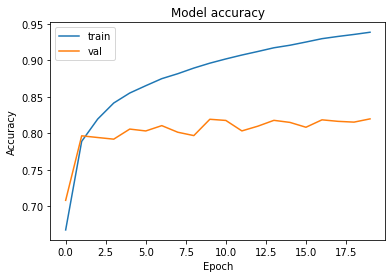

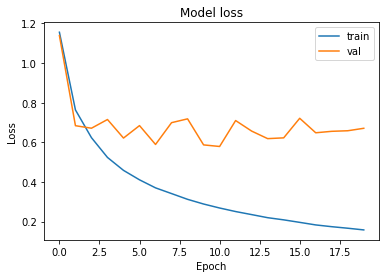

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('acc_plot.png')
plt.show()
plt.close()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.savefig('loss_plot.png')
plt.show()
plt.close()


In [ ]:
# Slicing the image into crop_size*crop_size crops with a stride of crop_size/2 and makking list out of them

def crops(a, crop_size = 128):

    stride = 32

    croped_images = []
    h, w, c = a.shape

    n_h = int(int(h/stride))
    n_w = int(int(w/stride))

    # Padding using the padding function we wrote
    ##a = padding(a, w, h, c, crop_size, stride, n_h, n_w)

    # Resizing as required
    ##a = resize(a, stride, n_h, n_w)

    # Adding pixals as required
    a = add_pixals(a, h, w, c, n_h, n_w, crop_size, stride)

    # Slicing the image into 128*128 crops with a stride of 64
    for i in range(n_h-1):
        for j in range(n_w-1):
            crop_x = a[(i*stride):((i*stride)+crop_size), (j*stride):((j*stride)+crop_size), :]
            croped_images.append(crop_x)
    return croped_images


#### Making array of all the training sat images as it is without any cropping


In [ ]:
xtrain_list = []

for fname in filelist_trainx[:13]:

    # Reading the image
    tif = TIFF.open(fname)
    image = tif.read_image()

    crop_size = 128

    stride = 32

    h, w, c = image.shape

    n_h = int(int(h/stride))
    n_w = int(int(w/stride))


    image = padding(image, w, h, c, crop_size, stride, n_h, n_w)

    xtrain_list.append(image)


#### Making array of all the training gt images as it is without any cropping


In [ ]:
ytrain_list = []

for fname in filelist_trainy[:13]:

    # Reading the image
    tif = TIFF.open(fname)
    image = tif.read_image()

    crop_size = 128

    stride = 32

    h, w, c = image.shape

    n_h = int(int(h/stride))
    n_w = int(int(w/stride))


    image = padding(image, w, h, c, crop_size, stride, n_h, n_w)

    ytrain_list.append(image)


In [ ]:
y_train = np.asarray(ytrain_list)
x_train = np.asarray(xtrain_list)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


#### Making array of all the training sat images as it is without any cropping


In [ ]:
# Reading the image
tif = TIFF.open(filelist_trainx[13])
image = tif.read_image()

crop_size = 128

stride = 32

h, w, c = image.shape

n_h = int(int(h/stride))
n_w = int(int(w/stride))

image = add_pixals(image, h, w, c, n_h, n_w, crop_size, stride)

#x_val = np.reshape(image, (1,h,w,c))
x_val = image


#### Making array of all the training gt images as it is without any cropping


In [ ]:
# Reading the image
tif = TIFF.open(filelist_trainy[13])
image = tif.read_image()

crop_size = 128

stride = 32

h, w, c = image.shape

n_h = int(int(h/stride))
n_w = int(int(w/stride))


image = add_pixals(image, h, w, c, n_h, n_w, crop_size, stride)

#y_val1 = np.reshape(image, (1,h,w,c))
y_val = image

In [ ]:
xtest_list1 = []

for fname in filelist_testx:

    # Reading the image
    tif = TIFF.open(fname)
    image = tif.read_image()

    crop_size = 128

    stride = 32

    h, w, c = image.shape

    n_h = int(int(h/stride))
    n_w = int(int(w/stride))


    image = add_pixals(image, h, w, c, n_h, n_w, crop_size, stride)

    xtest_list1.append(image)

In [ ]:
def testing(model, trainx, trainy, testx, testy, weights_file = "model_onehot.h5"):

    pred_train_all = []
    pred_val_all = []

    model.load_weights(weights_file)

    Y_pred_train = model.predict(trainx)

    for k in range(Y_pred_train.shape[0]):

        pred_train_all.append(Y_pred_train[k])

    Y_gt_train = [rgb_to_onehot(arr, color_dict) for arr in trainy]

    Y_pred_val = model.predict(testx)

    for k in range(Y_pred_val.shape[0]):

        pred_val_all.append(Y_pred_val[k])

    Y_gt_val = [rgb_to_onehot(arr, color_dict) for arr in testy]

    return pred_train_all, Y_gt_train, pred_val_all, Y_gt_val

In [ ]:
def testing_diffsizes(model, trainx, trainy, testx, testy, weights_file = "model_augment.h5"):

    pred_train_all = []
    pred_test_all = []


    model.load_weights(weights_file)

    for i in range(len(trainx)):
        img = trainx[i]
        h,w,c = img.shape
        img = np.reshape(img, (1,h,w,c))
        Y_pred_train = model.predict(img)
        bb,h,w,c = Y_pred_train.shape
        Y_pred_train = np.reshape(Y_pred_train, (h,w,c))
        pred_train_all.append(Y_pred_train)

#    for k in range(Y_pred_train.shape[0]):

#        pred_train_all.append(Y_pred_train[k])

    Y_gt_train = [rgb_to_onehot(arr, color_dict) for arr in trainy]

    img = testx
    h,w,c = img.shape
    img = np.reshape(img, (1,h,w,c))
    Y_pred_test = model.predict(img)
    bb,h,w,c = Y_pred_test.shape
    Y_pred_test = np.reshape(Y_pred_test, (h,w,c))
    pred_test_all.append(Y_pred_test)

#    for k in range(Y_pred_val.shape[0]):

#        pred_test_all.append(Y_pred_val[k])

    Y_gt_val = [rgb_to_onehot(testy, color_dict)]

    return pred_train_all, Y_gt_train, pred_test_all, Y_gt_val

In [ ]:
##pred_train_all, Y_gt_train, pred_val_all, Y_gt_val = testing(model, trainx, trainy, testx, testy, weights_file = "model_onehot.h5")

pred_train_3, Y_gt_train_3, pred_val_all, Y_gt_val = testing_diffsizes(model, x_train, y_train, x_val, y_val, weights_file = "model_onehot.h5")

print(pred_val_all[0].shape)
print(Y_gt_val[0].shape)

(704, 864, 9)
(704, 864, 9)


In [ ]:
# Convert onehot to label
def to_class_no(y_hot_list):
    y_class_list = []

    n = len(y_hot_list)

    for i in range(n):

        out = np.argmax(y_hot_list[i])

        y_class_list.append(out)

    return y_class_list

#Confusion matrix

In [ ]:
def conf_matrix(Y_gt, Y_pred, num_classes = 9):

    total_pixels = 0
    kappa_sum = 0
    sudo_confusion_matrix = np.zeros((num_classes, num_classes))

#    if len(Y_pred.shape) == 3:
#        h,w,c = Y_pred.shape
#        Y_pred = np.reshape(Y_pred, (1,))

    n = len(Y_pred)

    for i in range(n):
        y_pred = Y_pred[i]
        y_gt = Y_gt[i]

        #y_pred_hotcode = hotcode(y_pred)
        #y_gt_hotcode = hotcode(y_gt)

        pred = np.reshape(y_pred, (y_pred.shape[0]*y_pred.shape[1], y_pred.shape[2]))
        gt = np.reshape(y_gt, (y_gt.shape[0]*y_gt.shape[1], y_gt.shape[2]))

        pred = [i for i in pred]
        gt = [i for i in gt]

        pred = to_class_no(pred)
        gt = to_class_no(gt)

#        pred.tolist()
#        gt.tolist()

        gt = np.asarray(gt, dtype = 'int32')
        pred = np.asarray(pred, dtype = 'int32')

        conf_matrix = confusion_matrix(gt, pred, labels=[0,1,2,3,4,5,6,7,8])

        kappa = cohen_kappa_score(gt,pred, labels=[0,1,2,3,4,5,6,7])

        pixels = len(pred)
        total_pixels = total_pixels+pixels

        sudo_confusion_matrix = sudo_confusion_matrix + conf_matrix

        kappa_sum = kappa_sum + kappa

    final_confusion_matrix = sudo_confusion_matrix

    final_kappa = kappa_sum/n

    return final_confusion_matrix, final_kappa

In [ ]:
confusion_matrix_train, kappa_train = conf_matrix(Y_gt_train_3, pred_train_3, num_classes = 9)
print('Confusion Matrix for training')
print(confusion_matrix_train)
print('Kappa Coeff for training without unclassified pixels')
print(kappa_train)

confusion_matrix_test, kappa_test = conf_matrix(Y_gt_val, pred_val_all, num_classes = 9)
print('Confusion Matrix for validation')
print(confusion_matrix_test)
print('Kappa Coeff for validation without unclassified pixels')
print(kappa_test)


Confusion Matrix for training
[[5.067813e+06 2.931000e+03 4.290000e+02 7.800000e+02 1.032900e+04
  9.010000e+02 1.900000e+02 0.000000e+00 4.327000e+04]
 [1.947000e+03 1.475129e+06 1.900000e+01 9.600000e+01 5.780000e+02
  1.229000e+03 5.500000e+01 0.000000e+00 3.692200e+04]
 [1.680000e+02 4.030000e+02 1.654930e+05 9.000000e+00 4.700000e+01
  9.500000e+01 0.000000e+00 0.000000e+00 3.069000e+03]
 [2.500000e+01 2.200000e+01 0.000000e+00 1.796070e+05 2.620000e+02
  0.000000e+00 0.000000e+00 0.000000e+00 1.695000e+03]
 [9.218000e+03 9.640000e+02 2.200000e+01 2.180000e+02 3.762205e+06
  1.620000e+02 7.000000e+00 0.000000e+00 8.151200e+04]
 [5.830000e+02 8.337000e+03 1.690000e+02 2.300000e+01 5.440000e+02
  1.195257e+06 0.000000e+00 0.000000e+00 3.798800e+04]
 [3.380000e+02 2.320000e+02 0.000000e+00 0.000000e+00 4.000000e+01
  0.000000e+00 8.889200e+05 0.000000e+00 6.170000e+03]
 [0.000000e+00 2.100000e+01 0.000000e+00 0.000000e+00 1.000000e+00
  2.000000e+00 0.000000e+00 2.654900e+04 9.000000

#Particular class accuracy

#### Pass Confusion matrix, label to which the accuracy needs to be found, number of classes to be considered


In [ ]:
def acc_of_class(class_label, conf_matrix, num_classes = 8):

    numerator = conf_matrix[class_label, class_label]

    denorminator = 0

    for i in range(num_classes):
        denorminator = denorminator + conf_matrix[class_label, i]

    acc_of_class = numerator/denorminator

    return acc_of_class


## On training

#### Find accuray of all the classes NOT considering the unclassified pixels

In [ ]:
for i in range(8):
    acc_of_cl = acc_of_class(class_label = i, conf_matrix = confusion_matrix_train, num_classes = 8)
    print('Accuracy of class '+str(i) + ' WITHOUT unclassified pixels - Training')
    print(acc_of_cl)

Accuracy of class 0 WITHOUT unclassified pixels - Training
0.9969390402789644
Accuracy of class 1 WITHOUT unclassified pixels - Training
0.9973469510558445
Accuracy of class 2 WITHOUT unclassified pixels - Training
0.9956562283789069
Accuracy of class 3 WITHOUT unclassified pixels - Training
0.9982825318481958
Accuracy of class 4 WITHOUT unclassified pixels - Training
0.9971927981263763
Accuracy of class 5 WITHOUT unclassified pixels - Training
0.991986143397905
Accuracy of class 6 WITHOUT unclassified pixels - Training
0.9993142446010814
Accuracy of class 7 WITHOUT unclassified pixels - Training
0.9990968276069695


#### Find accuray of all the classes considering the unclassified pixels

In [ ]:
for i in range(9):
    acc_of_cl = acc_of_class(class_label = i, conf_matrix = confusion_matrix_train, num_classes = 9)
    print('Accuracy of class '+str(i) + ' WITH unclassified pixels - Training')
    print(acc_of_cl)

Accuracy of class 0 WITH unclassified pixels - Training
0.9885246544376115
Accuracy of class 1 WITH unclassified pixels - Training
0.9730562839096951
Accuracy of class 2 WITH unclassified pixels - Training
0.9776056803950758
Accuracy of class 3 WITH unclassified pixels - Training
0.9889654261030444
Accuracy of class 4 WITH unclassified pixels - Training
0.9761038816825225
Accuracy of class 5 WITH unclassified pixels - Training
0.9616670997931452
Accuracy of class 6 WITH unclassified pixels - Training
0.992430501283912
Accuracy of class 7 WITH unclassified pixels - Training
0.96636697848797
Accuracy of class 8 WITH unclassified pixels - Training
0.8861045980654246


## On validation


#### Find accuray of all the classes NOT considering the unclassified pixels

In [ ]:
for i in range(8):
    acc_of_cl = acc_of_class(class_label = i, conf_matrix = confusion_matrix_test, num_classes = 8)
    print('Accuracy of class '+str(i) + ' WITHOUT unclassified pixels - Validation')
    print(acc_of_cl)


Accuracy of class 0 WITHOUT unclassified pixels - Validation
0.9322453861927547
Accuracy of class 1 WITHOUT unclassified pixels - Validation
0.9935665319036737
Accuracy of class 2 WITHOUT unclassified pixels - Validation
nan
Accuracy of class 3 WITHOUT unclassified pixels - Validation
nan
Accuracy of class 4 WITHOUT unclassified pixels - Validation
0.9817397879563042
Accuracy of class 5 WITHOUT unclassified pixels - Validation
0.5171467764060357
Accuracy of class 6 WITHOUT unclassified pixels - Validation
0.9998542794116908
Accuracy of class 7 WITHOUT unclassified pixels - Validation
nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


#### Find accuray of all the classes considering the unclassified pixels

In [ ]:
for i in range(9):
    acc_of_cl = acc_of_class(class_label = i, conf_matrix = confusion_matrix_test, num_classes = 9)
    print('Accuracy of class '+str(i) + ' WITH unclassified pixels - Validation')
    print(acc_of_cl)

Accuracy of class 0 WITH unclassified pixels - Validation
0.7596451269606039
Accuracy of class 1 WITH unclassified pixels - Validation
0.8681575228850525
Accuracy of class 2 WITH unclassified pixels - Validation
nan
Accuracy of class 3 WITH unclassified pixels - Validation
nan
Accuracy of class 4 WITH unclassified pixels - Validation
0.9166935817027829
Accuracy of class 5 WITH unclassified pixels - Validation
0.2337622074097039
Accuracy of class 6 WITH unclassified pixels - Validation
0.9853081718651738
Accuracy of class 7 WITH unclassified pixels - Validation
nan
Accuracy of class 8 WITH unclassified pixels - Validation
0.577306471891277


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


#Overall accuracy

### Calulating over all accuracy with and without unclassified pixels

In [ ]:
def overall_acc(conf_matrix, include_unclassified_pixels = False):

    if include_unclassified_pixels:

        numerator = 0
        for i in range(9):

            numerator = numerator + conf_matrix[i,i]

        denominator = 0
        for i in range(9):
            for j in range(9):

                denominator = denominator + conf_matrix[i,j]

        acc = numerator/denominator

        return acc

    else:

        numerator = 0
        for i in range(8):

            numerator = numerator + conf_matrix[i,i]

        denominator = 0
        for i in range(8):
            for j in range(8):

                denominator = denominator + conf_matrix[i,j]

        acc = numerator/denominator

        return acc


## Training


#### Over all accuracy without unclassified pixels

In [ ]:
print('Over all accuracy WITHOUT unclassified pixels - Training')
print(overall_acc(conf_matrix = confusion_matrix_train, include_unclassified_pixels = False))


Over all accuracy WITHOUT unclassified pixels - Training
0.9967665359434649


#### Over all accuracy with unclassified pixels

In [ ]:
print('Over all accuracy WITH unclassified pixels - Training')
print(overall_acc(conf_matrix = confusion_matrix_train, include_unclassified_pixels = True))


Over all accuracy WITH unclassified pixels - Training
0.9472324082501655


## Validation



#### Over all accuracy without unclassified pixels

In [ ]:
print('Over all accuracy WITHOUT unclassified pixels - Validation')
print(overall_acc(conf_matrix = confusion_matrix_test, include_unclassified_pixels = False))

Over all accuracy WITHOUT unclassified pixels - Validation
0.9783767813217167


#### Over all accuracy with unclassified pixels

In [ ]:
print('Over all accuracy WITH unclassified pixels - Validation')
print(overall_acc(conf_matrix = confusion_matrix_test, include_unclassified_pixels = True))


Over all accuracy WITH unclassified pixels - Validation
0.8291163589015151


#### Convert decimal onehot encode from prediction to actual onehot code


In [ ]:
def dec_to_onehot(pred_all):

    pred_all_onehot_list = []

    for img in pred_all:

        h, w, c = img.shape

        for i in range(h):
            for j in range(w):

                argmax_index = np.argmax(img[i,j])

                sudo_onehot_arr = np.zeros((9))

                sudo_onehot_arr[argmax_index] = 1

                onehot_encode = sudo_onehot_arr

                img[i,j,:] = onehot_encode

        pred_all_onehot_list.append[img]

    return pred_all_onehot_list


# Pred on train, val, test and save outputs

In [ ]:
weights_file = "model_onehot.h5"
model.load_weights(weights_file)

#y_pred_test_all = []

xtrain_list.append(x_val)

for i_ in range(len(xtrain_list)):

    item = xtrain_list[i_]

    h,w,c = item.shape

    item = np.reshape(item,(1,h,w,c))

    y_pred_train_img = model.predict(item)

    ba,h,w,c = y_pred_train_img.shape

    y_pred_train_img = np.reshape(y_pred_train_img,(h,w,c))

    img = y_pred_train_img
    h, w, c = img.shape

    for i in range(h):
        for j in range(w):

            argmax_index = np.argmax(img[i,j])

            sudo_onehot_arr = np.zeros((9))

            sudo_onehot_arr[argmax_index] = 1

            onehot_encode = sudo_onehot_arr

            img[i,j,:] = onehot_encode

    y_pred_train_img = onehot_to_rgb(img, color_dict)

    tif = TIFF.open(filelist_trainx[i_])
    image2 = tif.read_image()

    h,w,c = image2.shape

    y_pred_train_img = y_pred_train_img[:h, :w, :]

    imx = Image.fromarray(y_pred_train_img)

    imx.save("/content/drive/My Drive/dataset/pred/pred"+str(i_+1)+".jpg")



for i_ in range(len(xtest_list1)):

    item = xtest_list1[i_]

    h,w,c = item.shape

    item = np.reshape(item,(1,h,w,c))

    y_pred_test_img = model.predict(item)

    ba,h,w,c = y_pred_test_img.shape

    y_pred_test_img = np.reshape(y_pred_test_img,(h,w,c))

    img = y_pred_test_img
    h, w, c = img.shape

    for i in range(h):
        for j in range(w):

            argmax_index = np.argmax(img[i,j])

            sudo_onehot_arr = np.zeros((9))

            sudo_onehot_arr[argmax_index] = 1

            onehot_encode = sudo_onehot_arr

            img[i,j,:] = onehot_encode

    y_pred_test_img = onehot_to_rgb(img, color_dict)

    tif = TIFF.open(filelist_testx[i_])
    image2 = tif.read_image()

    h,w,c = image2.shape

    y_pred_test_img = y_pred_test_img[:h, :w, :]

    imx = Image.fromarray(y_pred_test_img)

    imx.save("/content/drive/My Drive/dataset/out/out"+str(i_+1)+".jpg")